In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
from xopt import Xopt

# set values if testing
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")

YAML = """
generator:
    name: bayesian_exploration

evaluator:
    function: xopt.resources.test_functions.tnk.evaluate_TNK

vocs:
    variables:
        x1: [0, 3.14159]
        x2: [0, 3.14159]
    objectives: {y1: MINIMIZE}
    constraints:
        c1: [GREATER_THAN, 0]
        c2: [LESS_THAN, 0.5]
    constants: {a: dummy_constant}

"""

In [2]:

X = Xopt.from_yaml(YAML)


# for testing purposes only
if SMOKE_TEST:
    X.generator.numerical_optimizer.n_restarts = 1
    X.generator.n_monte_carlo_samples = 1

X


            Xopt
________________________________
Version: 0+untagged.1.gaed4298
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  computation_time: null
  fixed_features: null
  max_travel_distances: null
  model: null
  model_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    use_low_noise_prior: true
  n_candidates: 1
  n_monte_carlo_samples: 128
  name: bayesian_exploration
  numerical_optimizer:
    max_iter: 2000
    n_raw_samples: 20
    n_restarts: 20
    name: LBFGS
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_torch: false
strict: true
vocs:
  constants:
    a: dummy_constant
  constraints:
    c1:
    - GREATER_THAN
    - 0.0
    c2:
    - LESS_THAN
    - 0.5
  objectives:
    y1: MINIMIZE
  observable

In [3]:
X.random_evaluate(5)

for i in range(5):
    print(f"step {i}")
    X.step()

step 0
step 1
step 2
step 3
step 4


In [4]:
print(X.data)

          x1        x2               a        y1        y2         c1  \
0   1.857411  2.653274  dummy_constant  1.857411  2.653274   9.583867   
1   1.690822  3.116700  dummy_constant  1.690822  3.116700  11.582595   
2   3.109037  2.939340  dummy_constant  3.109037  2.939340  17.215734   
3   0.561442  2.403776  dummy_constant  0.561442  2.403776   5.179652   
4   2.889524  1.595812  dummy_constant  2.889524  1.595812   9.917735   
6   0.619768  0.234017             NaN  0.619768  0.234017  -0.648565   
7   1.763425  0.000000             NaN  1.763425  0.000000   2.009668   
8   1.221947  1.316749             NaN  1.221947  1.316749   2.144291   
9   0.000000  1.032824             NaN  0.000000  1.032824  -0.033276   
10  0.661994  1.095908             NaN  0.661994  1.095908   0.713741   

           c2  xopt_runtime  xopt_error  
0    6.479154      0.000046       False  
1    8.265176      0.000010       False  
2   12.757454      0.000008       False  
3    3.628136      0.000007 

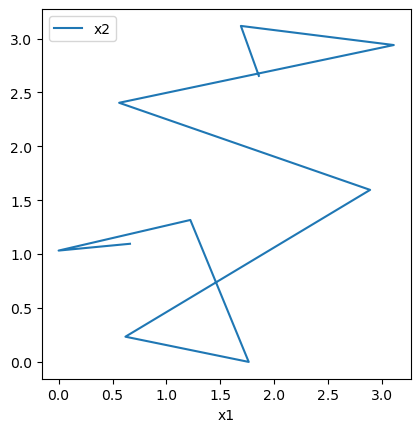

In [5]:
# plot results
ax = X.data.plot("x1", "x2")
ax.set_aspect("equal")

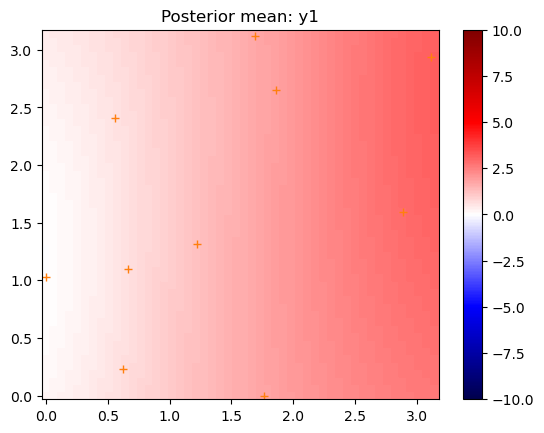

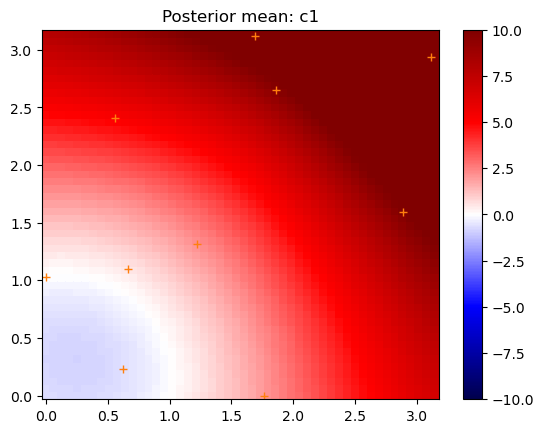

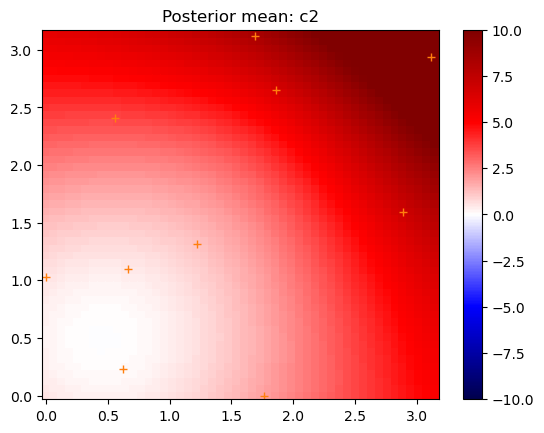

In [6]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = X.generator.vocs.bounds
model = X.generator.model

# create mesh
n = 50
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = X.generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    for i in range(len(X.vocs.output_names)):
        mean = post.mean[...,i]
        fig, ax = plt.subplots()
        ax.plot(*data[["x1", "x2"]].to_numpy().T, "+C1")
        c = ax.pcolor(
            xx, yy, mean.squeeze().reshape(n, n),
            cmap="seismic",
            vmin=-10.0,
            vmax=10.0)
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")

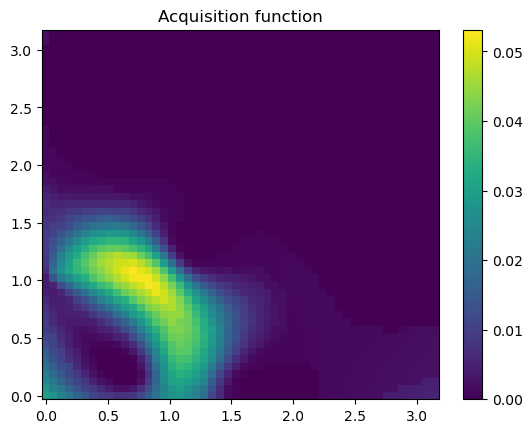

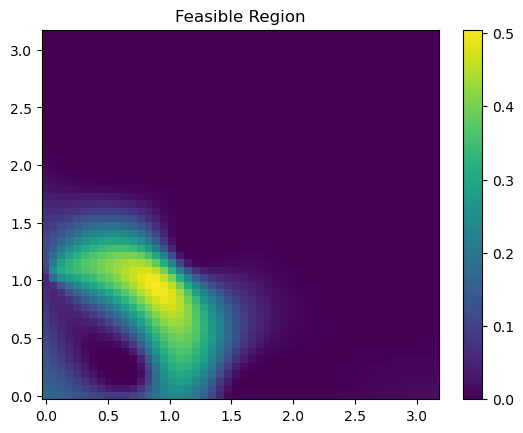

In [7]:
from xopt.generators.bayesian.objectives import feasibility

acq_func = X.generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n))
    fig.colorbar(c)
    ax.set_title("Acquisition function")

    feas = feasibility(pts.unsqueeze(1), model, X.vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title("Feasible Region")